Here, we create a multiclass classifier for classifying the various closest vectors returned by the model, as the corresponding attributes.

In [90]:
import warnings
warnings.filterwarnings('ignore')

from gensim.models.wrappers import FastText
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import pandas as pd
import numpy as np
import h5py
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing import sequence
from keras import models
from keras import layers
from keras import activations
from keras import optimizers
from keras import losses
from keras import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.preprocessing.text
from keras.models import load_model
from keras.utils import np_utils

import matplotlib.pyplot as plt
%matplotlib inline

## Prepare Dataset

In [91]:
#df = pd.read_csv('truthvalue.csv', encoding='utf8', dtype=object)

In [92]:
df = pd.read_csv('hospital_final_train.csv', encoding='utf8', dtype=object)

In [93]:
df.shape

(1000, 18)

In [94]:
df = df.drop(columns=['label'])

In [95]:
df.columns.values

array(['ProviderNumber', 'HospitalName', 'Address1', 'City', 'State',
       'ZipCode', 'CountyName', 'PhoneNumber', 'HospitalType',
       'HospitalOwner', 'EmergencyService', 'Condition', 'MeasureCode',
       'MeasureName', 'Score', 'Sample', 'Stateavg'], dtype=object)

## Data Cleaning

In [96]:
#df['ProviderNumber'] = df['ProviderNumber'].apply(lambda x: str(int(float(x))))
#df['ZipCode'] = df['ZipCode'].apply(lambda x: str(int(float(x))))
#df['PhoneNumber'] = df['PhoneNumber'].apply(lambda x: str(int(float(x))))

In [97]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,State,ZipCode,CountyName,PhoneNumber,HospitalType,HospitalOwner,EmergencyService,Condition,MeasureCode,MeasureName,Score,Sample,Stateavg
0,10018,callahan eye foundation hospital,1720 university blvd,birmingham,al,35233,jefferson,2053258100,acute care hospitals,voluntary non-profit - private,yes,surgical infection prevention,scip-card-2,surgery patients who were taking heart drugs c...,empty,empty,al_scip-card-2
1,10018,callahan eye foundation hospital,1720 university blvd,birmingham,al,35233,jefferson,2053258100,acute care hospitals,voluntary non-profit - private,yes,surgical infection prevention,scip-inf-1,surgery patients who were given an antibiotic ...,empty,empty,al_scip-inf-1


In [98]:
df.shape

(1000, 17)

In [99]:
values = []
for i in df.columns:
    values.append(df[i].tolist())

In [100]:
attributes = df.columns.tolist()

Create value, attribute-name tuple pairs

In [101]:
data = []
for i in range(len(values)):
    for value in values[i]:
        data.append([str(value), attributes[i]])

In [102]:
len(data)

17000

In [103]:
data[:10]

[['10018', 'ProviderNumber'],
 ['10018', 'ProviderNumber'],
 ['10018', 'ProviderNumber'],
 ['10018', 'ProviderNumber'],
 ['10018', 'ProviderNumber'],
 ['10018', 'ProviderNumber'],
 ['10018', 'ProviderNumber'],
 ['10018', 'ProviderNumber'],
 ['10019', 'ProviderNumber'],
 ['10019', 'ProviderNumber']]

In [104]:
data[-10:]

[['al_hf-4', 'Stateavg'],
 ['al_pn-2', 'Stateavg'],
 ['al_pn-3b', 'Stateavg'],
 ['al_pn-4', 'Stateavg'],
 ['al_px-5c', 'Stateavg'],
 ['al_pn-6', 'Stateavg'],
 ['al_pn-7', 'Stateavg'],
 ['al_scip-card-2', 'Stateavg'],
 ['al_scip-inf-1', 'Stateavg'],
 ['al_scip-inf-2', 'Stateavg']]

In [105]:
dfData = pd.DataFrame(data, columns=['Value','Label'])

In [106]:
dfData.head(2)

,Value,Label
0,10018,ProviderNumber
1,10018,ProviderNumber


In [107]:
dfData.tail()

,Value,Label
16995,al_pn-6,Stateavg
16996,al_pn-7,Stateavg
16997,al_scip-card-2,Stateavg
16998,al_scip-inf-1,Stateavg
16999,al_scip-inf-2,Stateavg


Convert labels to categorical attributes

In [108]:
dfData['Label'] = dfData['Label'].astype('category')

In [109]:
dfData["Label_Cat"] = dfData["Label"].cat.codes

In [110]:
dfData.tail()

,Value,Label,Label_Cat
16995,al_pn-6,Stateavg,15
16996,al_pn-7,Stateavg,15
16997,al_scip-card-2,Stateavg,15
16998,al_scip-inf-1,Stateavg,15
16999,al_scip-inf-2,Stateavg,15


In [111]:
dfData['Label_Cat'].value_counts()

15    1000
6     1000
16    1000
1     1000
2     1000
3     1000
4     1000
5     1000
7     1000
14    1000
8     1000
9     1000
10    1000
11    1000
12    1000
13    1000
0     1000
Name: Label_Cat, dtype: int64

Get the mapping

In [112]:
mapping = dict(enumerate(dfData['Label'].cat.categories))

In [113]:
mapping

{0: 'Address1',
 1: 'City',
 2: 'Condition',
 3: 'CountyName',
 4: 'EmergencyService',
 5: 'HospitalName',
 6: 'HospitalOwner',
 7: 'HospitalType',
 8: 'MeasureCode',
 9: 'MeasureName',
 10: 'PhoneNumber',
 11: 'ProviderNumber',
 12: 'Sample',
 13: 'Score',
 14: 'State',
 15: 'Stateavg',
 16: 'ZipCode'}

Drop the Label column

In [114]:
dfData.drop(['Label'], axis=1, inplace=True)

In [115]:
dfData.head()

,Value,Label_Cat
0,10018,11
1,10018,11
2,10018,11
3,10018,11
4,10018,11


Shuffle the data

In [116]:
dfData = dfData.sample(frac=1).reset_index(drop=True)

In [117]:
dfData.head(10)

,Value,Label_Cat
0,5 patients,12
1,acute care hospitals,7
2,de kalb,3
3,9072761131,10
4,surgical infection prevention,2
5,no,4
6,al_ami-7a,15
7,50 medical park east drive,0
8,10029,11
9,eliza coffee memorial hospital,5


Find the longest string in the value column

In [118]:
maxLength = dfData.Value.map(lambda x: len(str(x))).max()

In [119]:
X = dfData['Value'].tolist()
y = dfData['Label_Cat'].tolist()

## Tokenize and obtain the train, test split

In [120]:
batchSize = 32
maxSequenceLength = maxLength
maxWords = 2 * sum(dfData.nunique())

In [121]:
tokenizer = Tokenizer(num_words=maxWords)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1019 unique tokens.


In [122]:
data = pad_sequences(sequences, maxlen=maxSequenceLength)

In [123]:
labels = np.asarray(y)

In [124]:
data.shape

(17000, 184)

In [125]:
labels.shape

(17000,)

In [126]:
labels = to_categorical(labels)

In [127]:
labels.shape

(17000, 17)

In [128]:
indices = np.arange(data.shape[0])

In [129]:
data = data[indices]
labels = labels[indices]

## Train test split

In [130]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=22, stratify=labels)

In [131]:
len(X_train), len(y_train)

(13600, 13600)

In [132]:
len(X_test), len(y_test)

(3400, 3400)

## Model

In [133]:
embeddingDim = 100

**Architecture**
* 1 embedding layer 
* 1 dense layer, 32 hidden units and _relu_ activation
* 1 dense layer, 64 hidden units and _relu_ activation
* Output layer, _softmax_ activation

In [134]:
model = models.Sequential()
model.add(layers.Embedding(maxWords, embeddingDim, input_length=maxSequenceLength))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation=activations.relu))
model.add(layers.Dense(64, activation=activations.relu))
model.add(layers.Dense(labels.shape[1], activation=activations.softmax))

model.compile(optimizer=optimizers.Adam(), loss=losses.categorical_crossentropy, metrics=['accuracy'])

In [135]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 184, 100)          204000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 18400)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                588832    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_6 (Dense)              (None, 17)                1105      
Total params: 796,049
Trainable params: 796,049
Non-trainable params: 0
_________________________________________________________________


In [136]:
history = model.fit(X_train, y_train,
                    epochs=3,
                    batch_size=32, 
                    validation_split=0.1)

Train on 12240 samples, validate on 1360 samples
Epoch 1/3
12240/12240 [==============================] - 6s 452us/step - loss: 1.3724 - acc: 0.5836 - val_loss: 0.3706 - val_acc: 0.9037
Epoch 2/3
12240/12240 [==============================] - 5s 424us/step - loss: 0.2193 - acc: 0.9578 - val_loss: 0.1574 - val_acc: 0.9684
Epoch 3/3
12240/12240 [==============================] - 5s 423us/step - loss: 0.1115 - acc: 0.9739 - val_loss: 0.1482 - val_acc: 0.9669


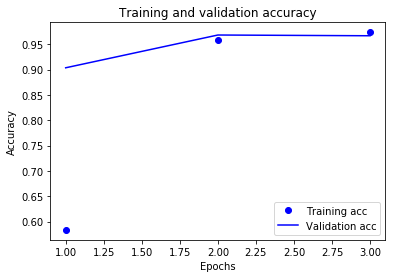

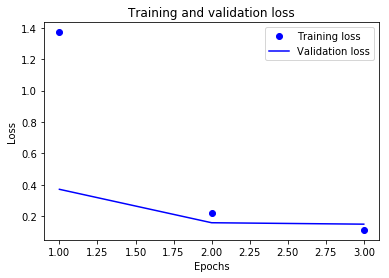

In [137]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

In [138]:
results = model.evaluate(X_test, y_test)

3400/3400 [==============================] - 0s 114us/step


In [139]:
loss = results[0]
accuracy = results[1]

In [140]:
loss

0.11736888301723143

In [141]:
accuracy

0.9741176470588235

Save the model

In [142]:
model.save("HospitalMultiAttributeClassifier.h5")

Save the tokenizer

In [143]:
with open('HospitalMultiAttributeClassifierTokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL, fix_imports=True)

## Make predictions on new data

In [144]:
model = load_model('HospitalMultiAttributeClassifier.h5')

In [145]:
with open('HospitalMultiAttributeClassifierTokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [146]:
testString = ['yes']

In [147]:
sequences = tokenizer.texts_to_sequences(testString)
testData = pad_sequences(sequences, maxlen=maxLength)

In [148]:
predictions = model.predict(testData)

In [149]:
#mapping = dict(enumerate(df.columns.astype('category').categories))

In [150]:
mapping[np.argmax(predictions[0])]

'EmergencyService'